# **Camera Calibration**
## Image Processing and Computer Vision - Lab Session No. 3

Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

## Exercise 1: 3D-2D correspondences

In [ ]:
import cv2
import numpy
import matplotlib.pyplot as plt

### Exercise 1A

Using image `chessboards/0.jpg` and the previous calibration results, find the 2D point corresponding to the 3D point `(53,53,0)` and draw a red circle around it.
Solve the exercise in two different ways:

1. Use the OpenCV function `cv2.projectPoints(object_points, rvec, tvec, camera_matrix, dist_coeffs)`;
1. Do it "manually" using the PPM matrix derived from the calibration parameters you already have.

2D point using cv2.projectPoints: [1374 1397]


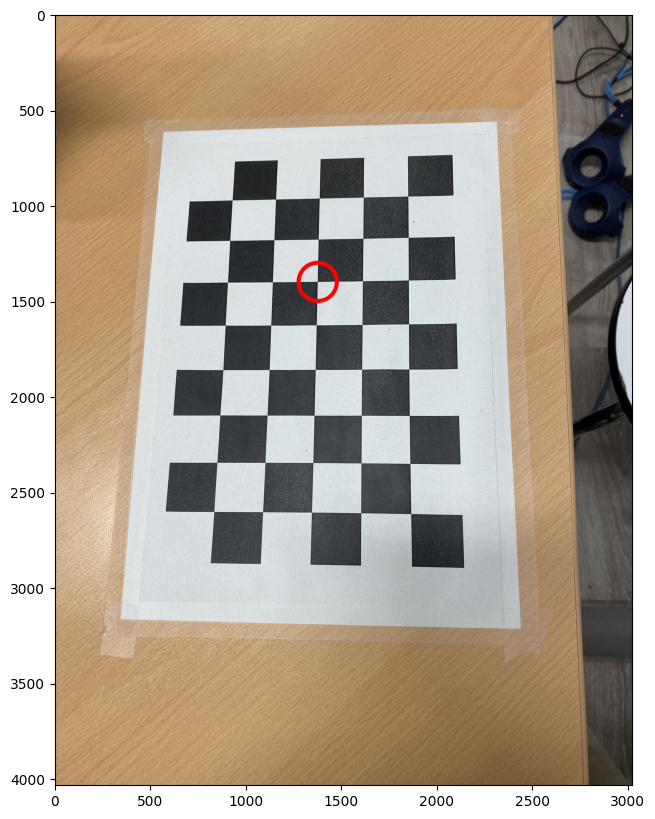


2D point using PPM: (1378, 1392)


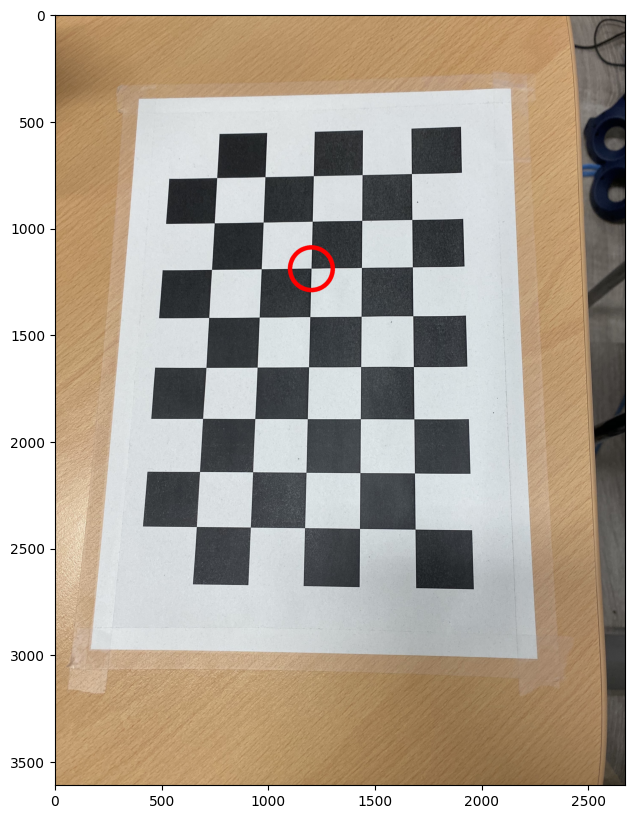

In [ ]:
# Read the image
img = cv2.imread("chessboards/0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define the 3D point
_3d_point = np.array([[53.,53.,0.]], dtype=np.float32)

# METHOD 1: use cv2.projectPoints
# projectPoints already computes distorsion coefficients, so no need to undistort the image.
# If you still want to use the undistorted image, you have to pass newcameramtx instead of camera_matrix
# and np.array([0.,0.,0.,0.,0.]) instead of dist_coefs, since distorsion is 0 in undistorted images.
_2d_point = cv2.projectPoints(_3d_point, rvecs[0], tvecs[0], camera_matrix, dist_coefs)[0][0,0]
_2d_point = np.round(_2d_point).astype(int)
print(f"2D point using cv2.projectPoints: {_2d_point}")

# Draw a circle around the point
img1 = np.copy(img)
cv2.circle(img1, (_2d_point[0], _2d_point[1]), 100, (255,0,0), 20)
plt.figure(figsize=(10,10))
plt.imshow(img1)
plt.show()

# METHOD 2: use the PPM
# First undistort the image to make the PPM work properly.
# You need to do it because the homography is a linear transformation and cannot remap nonlinear deformations.
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w,h), 1, (w,h))
img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

# Compute the PPM components: A, R and T
R = np.asarray(cv2.Rodrigues(rvecs[0])[0])
T = np.asarray(tvecs[0])
A = newcameramtx  # you are using the undistorted image, hence you need to use the new optimal A

# Build the PPM
PPM = np.matmul(A, np.concatenate((R,T), axis=1))

# Define the 3D point in homogeneous coordinates in order to multiply it with the PPM
_3d_point_homogeneous = np.array([[53.],[53.],[0.],[1.]])

# Multiply it with the PPM to obtain the pixel in homogeneous coordinates
_2d_point_homogeneous = np.matmul(PPM, _3d_point_homogeneous)

# Divide it by its third value to get the pixel coordinate
_2d_point = _2d_point_homogeneous / _2d_point_homogeneous[-1,0]
_2d_point = np.round(_2d_point).astype(int)

print(f"\n2D point using PPM: {int(round(_2d_point[0,0])), int(round(_2d_point[1,0]))}")

# Draw the point
img2 = np.copy(img_undistorted)
cv2.circle(img2, (_2d_point[0][0], _2d_point[1][0]), 100, (255,0,0), 20)

# Crop away the black region obtained by undistorting
img2 = img2[y:y+h_2, x:x+w_2]

plt.figure(figsize=(10,10))
plt.imshow(img2)
plt.show()

### Exercise 1B

Find the 3D point corresponding to the 2D point of corner `(2,2)`. Do it first using a new homography (calculated with `cv2.findHomography`) and then using the PPM derived from the calibration parameters.

The expected result is approximately `(53,53,0)`.

In [ ]:
# Read the image
img = cv2.imread("chessboards/0.jpg")

# METHOD 1: use cv2.findHomography
# Undistort the image to make the PPM work properly
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
x, y, w_2, h_2 = roi
img = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

# Build chessboard 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0] * pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:,:2] = coords_3D

def processImage(img):
    # processImage takes the undistorted image in this case
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    else:
        print("Chessboard not found")
        return None

    return corners.reshape(-1, 2)

corners = processImage(img)

# Get the position of corner (2,2)
_2d_point = corners[pattern_size[0] * 2 + 2]  # corner (2,2) 2D position
_2d_point_homogeneous = np.concatenate([_2d_point, [1]])

# Find the homography between 3D points and 2D points
homography = cv2.findHomography(pattern_points, corners, 0)[0]

# Use the inverse of the homography to project the 2D point to the 3D point
_3d_point_homogeneous = np.matmul(np.linalg.inv(homography), _2d_point_homogeneous)

# Transform homogeneous coordinates into Euclidean coordinates
_3d_point = _3d_point_homogeneous / _3d_point_homogeneous[-1]

# Force the 3D point to be on the chessboard plane
_3d_point[-1] = 0.

_3d_point = _3d_point.reshape([1,3])
print(f"3D point using new homography: {_3d_point[0]}")

# METHOD 2: use the PPM
R = np.asarray(cv2.Rodrigues(rvecs[0])[0])
T = np.asarray(tvecs[0])
A = newcameramtx  # you are using the undistorted image, hence you need to use the new optimal A

# Build the PPM
PPM = np.matmul(A, np.concatenate((R, T), axis=1))

# P as a homography
homography = np.concatenate([PPM[:, :2], PPM[:,3:]], axis=1)

# Use the inverse of the homography to project the 2D point to the 3D point
_3d_point_homogeneous = np.matmul(np.linalg.inv(homography), _2d_point_homogeneous)

# Transform homogeneous coordinates into Euclidean coordinates
_3d_point = _3d_point_homogeneous / _3d_point_homogeneous[-1]

# Force the 3D point to be on the chessboard plane
_3d_point[-1] = 0.

_3d_point = _3d_point.reshape([1,3])
print(f"\n3D point using PPM: {_3d_point[0]}")

3D point using new homography: [52.98660975 52.99351548  0.        ]

3D point using PPM: [52.99605164 52.98116132  0.        ]


## Exercise 2: 3D Measureaments in mm

Take an image with an object belonging to same plane of the chessboard. In our case, it will be `ex2/pen.jpg`. Measure the lenght of that object in mm. Image coordinates are provided for you.

Expected_results: `145.56mm`.

**Tips**:
* Find the homography given 2D-3D correspondences;
* Get the coordinates of two pixels of the object;
* Apply the same transformation as in Exercise 1B to get the 3D coordinates of those pixels;
* Find the Euclidean distance between two 3D points to get your measurements.

Distance: 145.56mm


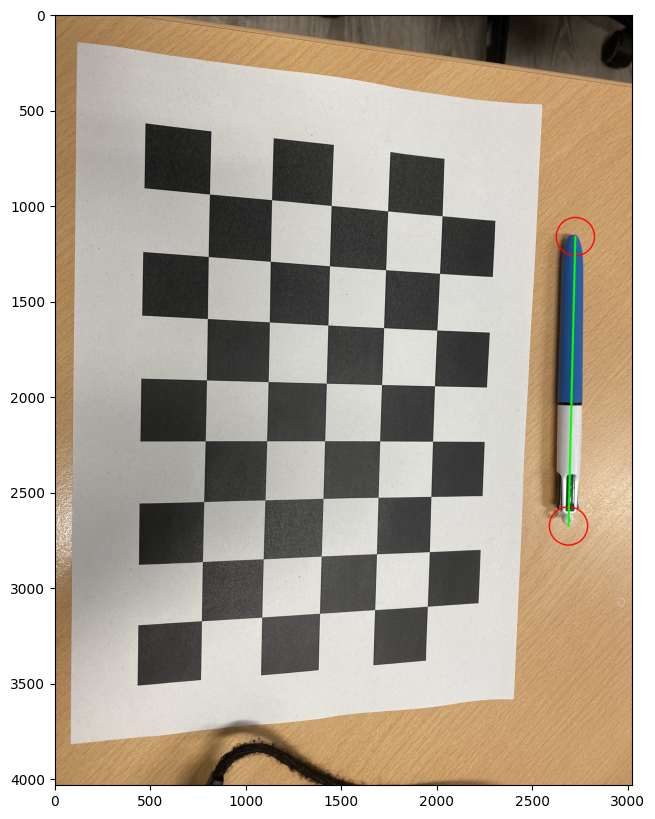

In [ ]:
# Distorsion will be ignored in this exercise

img_name = "lab_session_3_images/ex2/pen.jpg"
img = cv2.imread(img_name)

# Build 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0] * pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:, :2] = coords_3D

def processImage(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    else:
        print("Chessboard not found")
        return None

    return corners.reshape(-1, 2)

# Build 2D-3D correspondeces
corners = processImage(img_name)

# Find homography between the two sets of points
homography = cv2.findHomography(pattern_points, corners)[0]  # from 3D to 2D

# 2D points A,B
point2D_homogeneous_a = (2722, 1160, 1)
point2D_homogeneous_b = (2686, 2675, 1)

# Find 3D coordinates
point3D_homogeneous_a = np.matmul(np.linalg.inv(homography), point2D_homogeneous_a)
point3D_a = point3D_homogeneous_a / point3D_homogeneous_a[-1]
point3D_a[-1] = 0

point3D_homogeneous_b = np.matmul(np.linalg.inv(homography), point2D_homogeneous_b)
point3D_b = point3D_homogeneous_b / point3D_homogeneous_b[-1]
point3D_b[-1] = 0

# Draw line and circles
cv2.circle(img, (point2D_homogeneous_a[0], point2D_homogeneous_a[1]), 100, (0,0,255), 5)
cv2.circle(img, (point2D_homogeneous_b[0], point2D_homogeneous_b[1]), 100, (0,0,255), 5)
cv2.line(
    img,
    (point2D_homogeneous_a[0], point2D_homogeneous_a[1]),
    (point2D_homogeneous_b[0], point2D_homogeneous_b[1]),
    (0,255,0), 10)

dist = np.linalg.norm(point3D_a - point3D_b)
print(f"Distance: {dist:.2f}mm")

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Try this at home

## Exercise 3: Augmented Reality

Given an image, project it on the chessboard to cover all the corners of the image. Try to restore the values of the original image (the one with the chessboard) instead of the black pixels obtained with warping.
Image coordinates are provided for you.

Test the algorithm on `ex3/chessboard.jpg` and `ex3/stregatto.jpg`.

**Tips**:
* Find the perspective transformation;
* Warp the image;
* Understand what are the points to restore to the original values;
* Restore the values in those pixels;

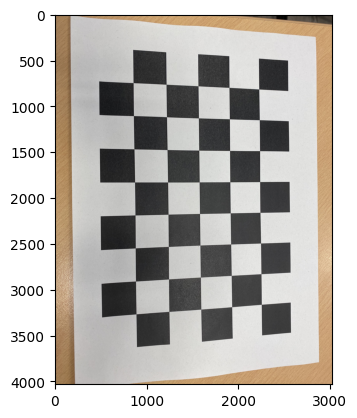

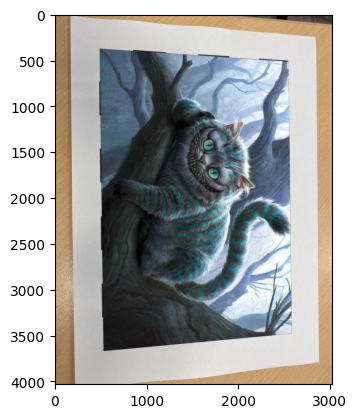

In [ ]:
# Distorsion will be ignored in this exercise

image = cv2.imread("lab_session_3_images/ex3/chessboard.jpg")
image2project = cv2.imread("lab_session_3_images/ex3/stregatto.jpg")

h, w = image.shape[0], image.shape[1]
h_2, w_2 = image2project.shape[0], image2project.shape[1]

# Coordinates of the chessboard perimeter
rect = np.array([
    [2537, 519],
    [2573, 3480],
    [530, 3670],
    [488, 380]], dtype="float32")

# Coordinate of the border of the image we want to project
src = np.array([
    [0, 0],
    [w_2-1, 0],
    [w_2-1, h_2-1],
    [0, h_2-1]], dtype="float32")

# Compute the perspective transformation matrix
M = cv2.getPerspectiveTransform(src, rect)

# Apply the transformation matrix
warped = cv2.warpPerspective(image2project, M, (w,h))

# Warp a white mask to understand which pixels are black
white = np.ones([h_2, w_2, 3], dtype=np.uint8) * 255
warp_mask = cv2.warpPerspective(white, M, (w,h))
warp_mask = np.equal(warp_mask, np.array([0,0,0]))

# Restore previous values
warped[warp_mask] = image[warp_mask]

# Display original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Display warped image
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()